In [38]:
import numpy as np

import astropy.units as u
from  astropy.coordinates import *

import sunpy.map
import sunpy.coordinates


import sunkit_image.coalignment as ski
import sunpy.physics.differential_rotation as diffrot

import matplotlib.pyplot as plt


This is my new function; I define it here so i can have a direct way to compare it with the actual version

In [39]:
def calculate_solar_rotate_shift(mc, layer_index=0, **kwargs):
       
    nt = len(mc.maps)
    xshift_arcseconds = np.zeros(nt) * u.arcsec
    yshift_arcseconds = np.zeros_like(xshift_arcseconds)
    observer_coordinate_ref_layer = mc.maps[layer_index].observer_coordinate

    for i, m in enumerate(mc):
        
        # Calculate the rotation of the center of the map 'm' at its
        # observation time to the observation time of the reference layer
        # indicated by "layer_index".
        new_coordinate = diffrot.solar_rotate_coordinate(m.center, observer=observer_coordinate_ref_layer, **kwargs)

        xshift_arcseconds[i] = new_coordinate.Tx - m.center.Tx
        yshift_arcseconds[i] = new_coordinate.Ty - m.center.Ty

    # Set the shifts relative to the reference layer
    # The shift of the reference layer is always zero by definition.
    xshift_ref=xshift_arcseconds[layer_index]
    yshift_ref=yshift_arcseconds[layer_index]
    xshift_arcseconds=xshift_arcseconds-xshift_ref
    yshift_arcseconds=yshift_arcseconds-yshift_ref
            

    return {"x": xshift_arcseconds, "y": yshift_arcseconds}

I use these 6 maps, given gently by @yjzhu-solar, to show the difference of the two methods.

He sad: "I prepared an AIA 193 map sequence consisting of six maps with one hour separation with each other. I manually made those cutouts so that the center coordinates of these maps are slightly different. "

In [40]:
map0 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T190103Z.193.image.fits')
map1 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T200103Z.193.image.fits')
map2 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T210103Z.193.image.fits')
map3 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T220103Z.193.image.fits')
map4 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T230103Z.193.image.fits')
map5 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-05T000103Z.193.image.fits')

In [41]:
#create map sequence
map_seq = sunpy.map.Map([map0, map1,map2,map3,map4,map5], sequence=True) 

Showing the plots of the images

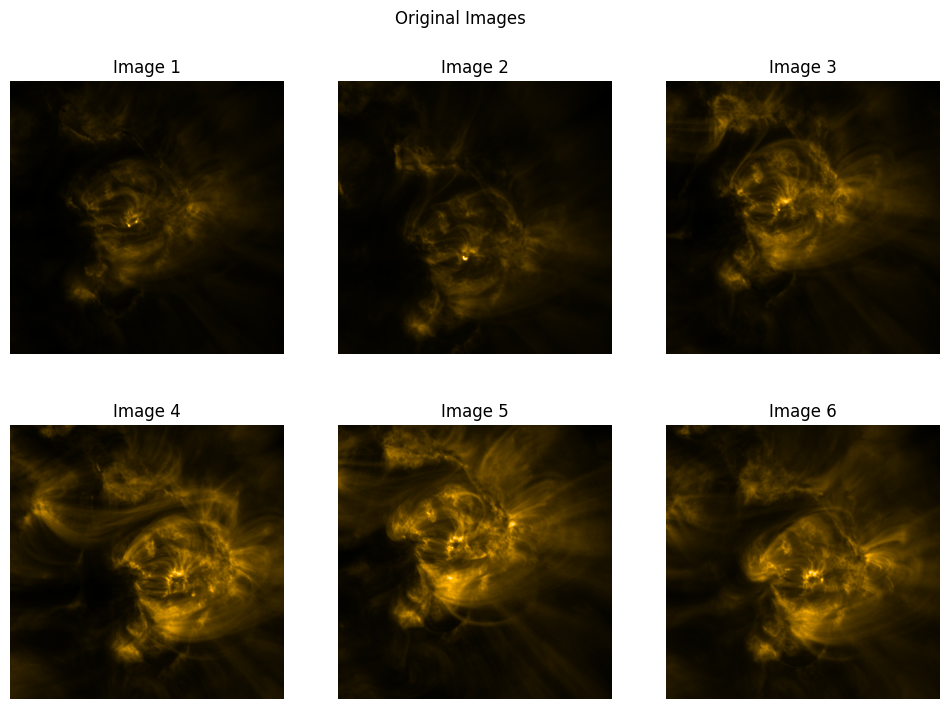

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the images and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(map_seq[i].data, cmap='sdoaia171')  # You may adjust the colormap as needed
    ax.set_title(f'Image {i+1}')  # Set titles for each subplot
    ax.axis('off')  # Turn off axis labels

# Adjust spacing between subplots
# plt.tight_layout
fig.suptitle('Original Images')  # Set the title for the entire figure
fig.subplots_adjust(top=0.9)  # Adjust the spacing between the title and the subplots
# Show the plot
plt.show()

In the following part i show the different results that i get with these two  methods;

From the fact that the images are taken with equal delay (1 hour) the rotation should be smooth and
 the difference between each position on the array should be nearly costant.
 
In the following prompt we can see that in new method there is a nearly constant shift ~ 6 arcsec in Tx and ~0.3 arcsec in Ty. 

In [42]:
#calculate the shift using the actual method
oldShift=ski.calculate_solar_rotate_shift(map_seq, layer_index=0)
oldShift

{'x': <Quantity [  0.        ,  -6.13211901,   5.69057894, -37.3097058 ,
              5.61144133, -18.91259736] arcsec>,
 'y': <Quantity [  0.        , -29.69907601,  12.61877265, -11.16255802,
             19.24286322, -10.53098087] arcsec>}

In [43]:
#calculate the shift using the new method
newShift=calculate_solar_rotate_shift(map_seq, layer_index=0)
newShift

{'x': <Quantity [  0.        ,  -6.13211901, -12.30921682, -19.30989953,
            -24.3882123 , -30.91246239] arcsec>,
 'y': <Quantity [0.        , 0.30072454, 0.61879132, 0.83742729, 1.2428831 ,
            1.4688969 ] arcsec>}

In [44]:
#apply the shift to the map sequence
mapOldShift=ski.mapsequence_coalign_by_rotation(map_seq,layer_index=0,shift=oldShift)
mapNewShift=ski.mapsequence_coalign_by_rotation(map_seq,layer_index=0,shift=newShift)

c:\Users\paolo\AppData\Local\Programs\Python\Python37\lib\site-packages\astropy\visualization\wcsaxes\patches.py:165: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


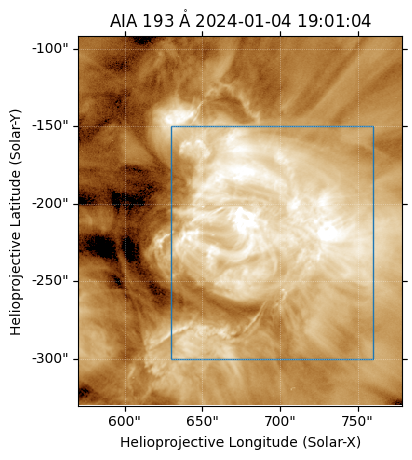

In [52]:
#find the rectangle area that is contained in all the maps
my_map=mapNewShift[0]
roi_bottom_left = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=my_map.coordinate_frame)
roi_top_right = SkyCoord(Tx=760*u.arcsec, Ty=-300*u.arcsec, frame=my_map.coordinate_frame)

fig = plt.figure()
ax = fig.add_subplot(projection=my_map)
my_map.plot(axes=ax, clip_interval=(1,99.5)*u.percent)
my_map.draw_quadrangle(roi_bottom_left, top_right=roi_top_right, axes=ax, color='C0')
plt.show()

c:\Users\paolo\AppData\Local\Programs\Python\Python37\lib\site-packages\astropy\visualization\wcsaxes\patches.py:165: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


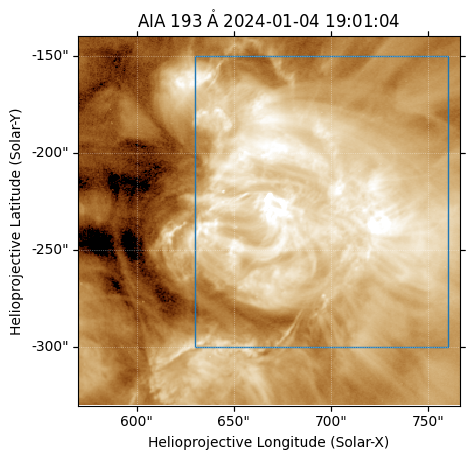

In [51]:
#find the rectangle area that is contained in all the maps
my_map=mapOldShift[0]
roi_bottom_left = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=my_map.coordinate_frame)
roi_top_right = SkyCoord(Tx=760*u.arcsec, Ty=-300*u.arcsec, frame=my_map.coordinate_frame)

fig = plt.figure()
ax = fig.add_subplot(projection=my_map)
my_map.plot(axes=ax, clip_interval=(1,99.5)*u.percent)
my_map.draw_quadrangle(roi_bottom_left, top_right=roi_top_right, axes=ax, color='C0')
plt.show()

In [47]:
mapNewShiftCropped=[]
for m in mapNewShift:
    mapNewShiftCropped.append(m.submap(roi_bottom_left,top_right=roi_top_right))

mapOldShiftCropped=[]
for m in mapOldShift:
    mapOldShiftCropped.append(m.submap(roi_bottom_left,top_right=roi_top_right))

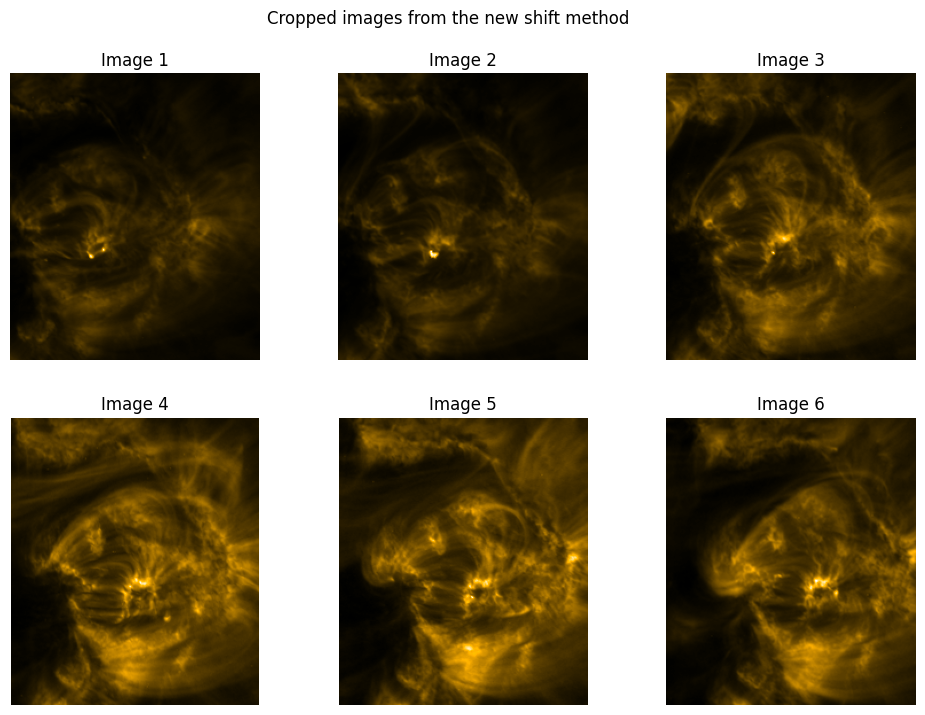

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the images and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(mapNewShiftCropped[i].data, cmap='sdoaia171')  # You may adjust the colormap as needed
    ax.set_title(f'Image {i+1}')  # Set titles for each subplot
    ax.axis('off')  # Turn off axis labels

# Adjust spacing between subplots
# plt.tight_layout
fig.suptitle('Cropped images from the new shift method')  # Set the title for the entire figure
fig.subplots_adjust(top=0.9)  # Adjust the spacing between the title and the subplots
# Show the plot
plt.show()

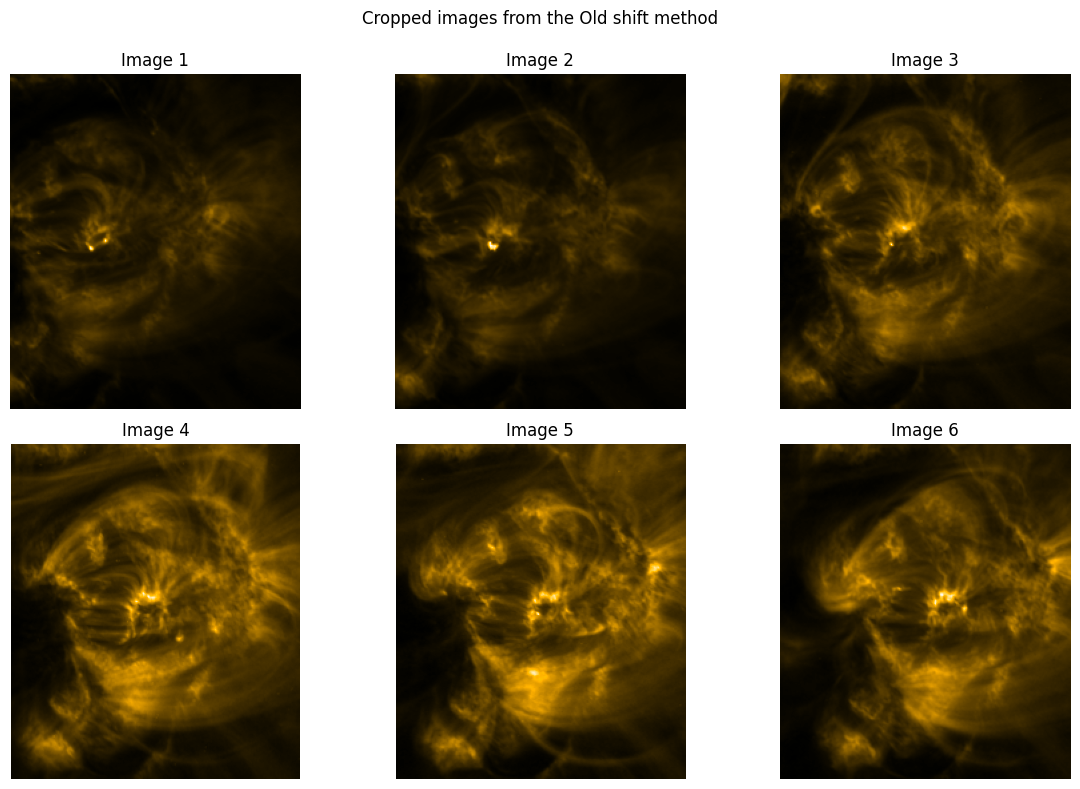

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the images and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(mapOldShiftCropped[i].data, cmap='sdoaia171')  # You may adjust the colormap as needed
    ax.set_title(f'Image {i+1}')  # Set titles for each subplot
    ax.axis('off')  # Turn off axis labels

# Adjust spacing between subplots
plt.tight_layout()

fig.suptitle('Cropped images from the Old shift method')  # Set the title for the entire figure
fig.subplots_adjust(top=0.9)  # Adjust the spacing between the title and the subplots

# Show the plot
plt.show()

It's hard to notice some differences in the imgaes becuase the difference consint in just tens of pixels.
(AIA has a spatial scale of 0.6 arcsec/pix)

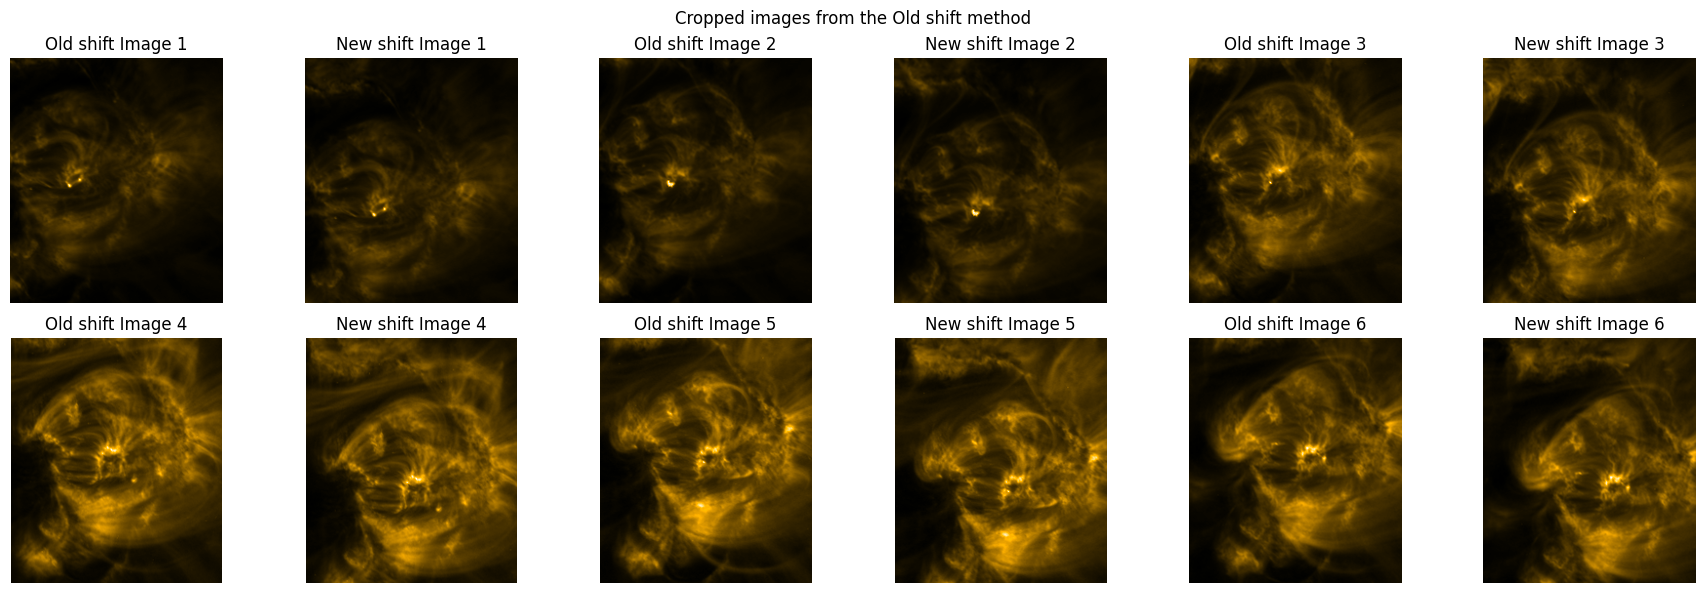

In [50]:
combinedArray=[None]*12

for i in range(6):
    combinedArray[2*i]=mapOldShiftCropped[i].data
    combinedArray[2*i+1]=mapNewShiftCropped[i].data



fig, axes = plt.subplots(2, 6, figsize=(18, 6))

# Iterate over the images and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(combinedArray[i], cmap='sdoaia171')  # You may adjust the colormap as needed
    if(i%2==0):
        ax.set_title(f'Old shift Image {i//2+1}')
    else:
        ax.set_title(f'New shift Image {i//2+1}')
    ax.axis('off')  # Turn off axis labels

# Adjust spacing between subplots
plt.tight_layout()

fig.suptitle('Cropped images from the Old shift method')  # Set the title for the entire figure
fig.subplots_adjust(top=0.9)  # Adjust the spacing between the title and the subplots

# Show the plot
plt.show()